## 19장 세상에 없는 얼굴 GAN, 오토인코더
- 이미지의 특징을 추출하는 오토인코더(Auto-Encoder, AE)
- GAN이 세상에 존재하지 않는 완전한 가상의 것을 만들어냄
- 실존하지 않지만 완전한 가상 이미지 생성
- AE는 입력 데이터의 특징을 효율적으로 담아낸 이미지를 만들어냄 초점이 좀 흐릿하고 윤곽이 불명확하지만 데이터의 특징을 유추할 수 있는 것들이 모아 이미지 생성
- AE 장점: 부족한 학습 데이터 수를 효과적으로 늘려줌

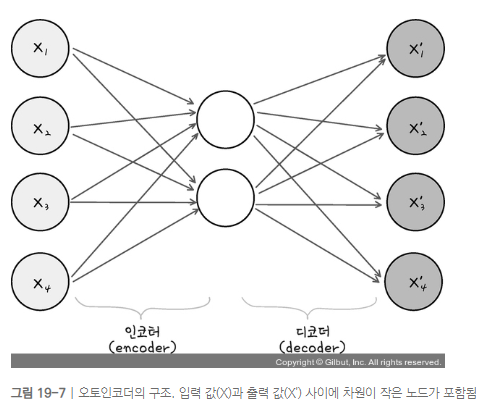

GAN이 세상에 존재하지 않는 완전한 가상의 것을 만들어 내는 반면
오토인코더는 입력 데이터의 특징을 효율적으로 담아낸 이미지를 만들어 낸다

예를 들어
GAN으로 사람의 얼굴을 만들면 진짜 같아 보여도 실제로는 존재하지 않는 완전한 가상 이미지가 만들어진다
하지만 오토인코더로 사람의 얼굴을 만들 경우 초점이 좀 흐릿하고 윤곽이 불명확하지만 사람의 특징을 유추할 수 있는 것들이 모여 이미지가 만들어진다

In [1]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras import models,layers

import numpy as np
import matplotlib.pyplot as plt
import os

os.environ['KMP_DUPLICATE_LIB_OK']="TRUE"

In [2]:
# MNIST 데이터셋을 불러옴
(X_train, _), (X_test, _) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype(float) / 255
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype(float) / 255

In [3]:
# 생성자 모델 만들기
autoencoder = models.Sequential()

# 인코딩 부분(축소)
autoencoder.add(layers.Conv2D(16, kernel_size=3, padding='same', input_shape=(28, 
28,1), activation='relu'))
autoencoder.add(layers.MaxPooling2D(pool_size=2, padding='same'))
autoencoder.add(layers.Conv2D(8, kernel_size=3, padding='same', activation='relu'))
autoencoder.add(layers.MaxPooling2D(pool_size=2, padding='same'))
autoencoder.add(layers.Conv2D(8, kernel_size=3, padding='same', activation='relu', 
                             strides=2))
# MaxPooling2D : 특징만 갖고 크기 줄이기
# Conv2D : 학습할 파라미터를 가지고 연산함


# 디코딩 부분(확장)
autoencoder.add(layers.Conv2D(8, kernel_size=3, padding='same', activation='relu'))
autoencoder.add(layers.UpSampling2D())
autoencoder.add(layers.Conv2D(8, kernel_size=3, padding='same', activation='relu'))
autoencoder.add(layers.UpSampling2D())
autoencoder.add(layers.Conv2D(16, kernel_size=3, activation='relu'))
autoencoder.add(layers.UpSampling2D())
autoencoder.add(layers.Conv2D(1, kernel_size=3, padding='same', 
                              activation='sigmoid'))

# 전체 구조 확인
# input_shape의 크기 집중
autoencoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 8)          0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 8)           584       
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 8)           5

Shape이 줄었다가 최종적으로는 처음과 같이 변함

In [4]:
# 컴파일 및 학습을 하는 부분
# 정확도 측정이 아니기 때문에 metrics값은 안줌
autoencoder.compile(loss='binary_crossentropy', optimizer='adam')

# 처음 X_train을 넣어서 변한 값 X_train을 결과로 다시 넣어줌
# X_train(입력값, 원데이터), X_train(target, autoencoder 과정을 지난 출력값)
autoencoder.fit(X_train, X_train, epochs=50, batch_size=128, 
                validation_data=(X_test, X_test))

Epoch 1/50
469/469 [==============================] - 101s 213ms/step - loss: 0.2018 - val_loss: 0.1376
Epoch 2/50
469/469 [==============================] - 88s 188ms/step - loss: 0.1285 - val_loss: 0.1195
Epoch 3/50
469/469 [==============================] - 93s 197ms/step - loss: 0.1161 - val_loss: 0.1105
Epoch 4/50
469/469 [==============================] - 89s 190ms/step - loss: 0.1086 - val_loss: 0.1049
Epoch 5/50
469/469 [==============================] - 83s 177ms/step - loss: 0.1041 - val_loss: 0.1011
Epoch 6/50
469/469 [==============================] - 81s 174ms/step - loss: 0.1011 - val_loss: 0.0987
Epoch 7/50
469/469 [==============================] - 84s 178ms/step - loss: 0.0988 - val_loss: 0.0967
Epoch 8/50
469/469 [==============================] - 90s 193ms/step - loss: 0.0971 - val_loss: 0.0957
Epoch 9/50
469/469 [==============================] - 84s 179ms/step - loss: 0.0957 - val_loss: 0.0939
Epoch 10/50
469/469 [==============================] - 81s 172ms/step - 

313/313 [==============================] - 4s 11ms/step


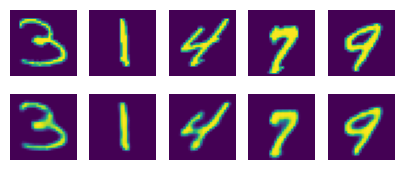

In [5]:
# 테스트할 이미지를 랜덤하게 불러옴
random_test = np.random.randint(X_test.shape[0], size=5)

# 앞서 만든 오토인코더 모델에 집어넣음
ae_imgs = autoencoder.predict(X_test)

# 출력될 이미지의 크기를 정함
plt.figure(figsize=(7, 2))

# 랜덤하게 뽑은 이미지를 차례로 나열
for i, image_idx in enumerate(random_test): 
   ax = plt.subplot(2, 7, i + 1) 
   # 테스트할 이미지를 먼저 그대로 보여줌
   plt.imshow(X_test[image_idx].reshape(28, 28))
   ax.axis('off')
   ax = plt.subplot(2, 7, 7 + i +1)
   # 오토인코딩 결과를 다음열에 출력
   plt.imshow(ae_imgs[image_idx].reshape(28, 28))
   ax.axis('off')
plt.show()